---
# Second Use Case - European Patents concerned with material science and chemicals
---

<a id="top"></a>
# Text Analysis, Keyword extraction and Topic Modelling
Using Abstracts from the patstat data set we aim to extract essential keywords which will act as suitable identifiers for Patents several fields. This will aid us in identifying regional knowledge bases and research hubs in a more automated fashion, at the moment keywords used for the search are suggested by experts. We will use a variety of approaches rooted in the research field of Natural Language Processing (NLP) and Textual Analysis as well as statistical modelling approaches which include:
- Latent Dirichlet Allocation
- Latent Semantiv Analysis
- Negative Matrix Factorization
- Uniform Manifold Approximation and Projection for Dimension Reduction

This notebook follows a variety of online and printed sources which will be credited in the [bibliography](#bibl).
***

# Table of Content

1. [Get and prepare the data](#chap1)
2. [Vectorizer](#chap3)
3. [Topic Modelling](#chap4)
4. [Results and visualisations](#chap5)

# 1. Get and prepare the data
<a id="chap1"></a>
Here we focus on importing the data from the data base, introducing stopwords, stemming and lemmatization (even though we prioritized lemmatization) using part-of-speech tagging (pos tagging) to improve the lemmatization quality, we could construct some features regarding length, number of words or stopwords as suggested in [1].

In [1]:
# load packages
import numpy as np
import pandas as pd
import pickle
import nltk
import psycopg2 as db
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [2]:
# necessary packages for [10]
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# defining stopwords and the lemmatizer based on: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
stop_words = nltk.corpus.stopwords.words('english')

stop_words.extend(['overall','result','end','likewise','present','method','invention','relates','also','lastly',
                       'firstly','include', 'includes', 'including','exclude','desired','according','embodiments','first','least',
                       'configured','time','certain','therefor','whose','receiving','following','steps','using','use','individual',
                       'needed','need','purpose','profile','n','said','may','wherein','target','determining','set','comprises',
                       '1','2','10','comprising','provide','provided','used','means','proceeded','proceed','one','two','second', '100', 'preferably',
                       'problem','to','be','solved','solution','jpo','ncipi','problems','means','for','solving','utility','discloses','provides',
                        '<id>','</id>','<br>','</br>','<p>','</p>','<ul>','</ul>','<ol>','</ol>','<li>','</li>','<p id=','num=',
                        '<img id=','file='])

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# Init Lemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [4]:
# establish connection and read data from postgres
# source: https://pynative.com/python-postgresql-tutorial/
try:
    connection = db.connect(user = XXX,
                                  password = XXX,
                                  host = XXX,
                                  port = XXX,
                                  database = XXX)
    #connection.set_client_encoding('UTF8')
    cursor = connection.cursor()
    # 19 mio distinct abstracts, some are in there multiple times because of multiple ipcs (32mio)
    # with c08 the total is about 5mio
    cursor.execute("SELECT * from thesis.material_science WHERE appln_abstract_lg = 'en' and LENGTH(nuts) > 2")
    returnlist = []
    row = cursor.fetchone()
    returnlist.append(row)
    errorcnt = 0
    while row is not None:
        try:
            row = cursor.fetchone()
            if row is not None:
                #row['appln_abstract'] = stem.stemabstract(row['appln_abstract'])
                returnlist.append(row)
        except UnicodeDecodeError:
            errorcnt = errorcnt + 1
    print("Couldn't decode " + str(errorcnt) + " abstracts")
    record = returnlist
except (Exception, db.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

Couldn't decode 45 abstracts
PostgreSQL connection is closed


In [5]:
len(record)

207048

In [6]:
record[1000]

(16938897,
 'en',
 'To prepare thermoplastic moulding composition from â€¦ â€¦Â\xa0Â\xa0A) 5-95% by weight of a modified polyphenylene ether, â€¦Â\xa0Â\xa0B) from 5 to 95% by weight of a thermoplastic polyamide, â€¦Â\xa0Â\xa0C) from 0 to 25% by weight of impact-modifying rubber, and â€¦Â\xa0Â\xa0D) from 0 to 50% by weight of auxiliaries and/or additives, â€¦ components A and B and, if used, components C and D are fed individually at one or more points into an extruder, mixed with one another and melted. Before it is fed in, component A, which has a pulverulent consistency, is compacted and/or sintered under pressure and optionally at elevated temperature, preferably under a pressure corresponding to a linear force of from 1 to 100Â\xa0kN/cm, to give a porous compact. The compact is subsequently modified and fed, as granules, to the feed zone of the extruder. In this way, the fines content of the polyphenylene ether is significantly reduced, so that there is virtually no longer any dang

In [7]:
id2word = corpora.Dictionary([[]])
print(id2word)

Dictionary(0 unique tokens: [])


In [8]:
# create a corpus
def makecorpus(record,stop_words):
    phrases = nltk.tokenize.sent_tokenize(record)
    #words = nltk.tokenize.word_tokenize(record)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(record)
    # stopwords
    #stop_words = stop_words
    corpus = [] 
    for w in words:
        if not w.isnumeric():
            if len(w) > 2:
                if w.lower() not in stop_words: 
                    # because of the need to compare each entry to wordnet lemmatizer takes ages
                    #token = stemmer.stem(w.lower())
                    token = (lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)))
                    id2word.add_documents([[token]])
                    corpus.append(token)
    #print(phrases)
    #print(words)
    #print(corpus)
    return corpus

In [9]:
# need to be able to perform this batchwise
corpuslist = []

for i in range(0, len(record)):
    dat = str(record[i][2]) # extract the column containing the abstract
    corpuslist.append(makecorpus(dat,stop_words))

In [18]:
#id2word.filter_extremes(no_below=5, no_above=0.95)#, keep_n=1000000)

In [13]:
print(id2word)

Dictionary(14201 unique tokens: ['cover', 'woven', 'layer', 'join', 'connect']...)


In [11]:
sentences = [record[i][2] for i in range(0,len(record))]

In [12]:
appids = [record[i][0] for i in range(0,len(record))]

In [13]:
ipcs = [record[i][4][0:4] for i in range(0,len(record))]

In [14]:
nuts = [record[i][6] for i in range(0,len(record))]

In [15]:
ctr = [record[i][7] for i in range(0,len(record))]

In [16]:
tokenslist = [','.join(corpuslist[i]) for i in range(0,len(corpuslist))]

In [20]:
del record

# 2. Vectorizers
<a id="chap3"></a>
We start by applying a simple bag of words vectorizer but will also use a tfidf weighted matrix. A one hot encoder would not proof beneficial for the approach at hand.

In [18]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in corpuslist]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [19]:
id2word[2]

'monodisperse'

In [20]:
len(corpus)

207048

Here we use tfidf scoring again to look at important keywords of the overall corpus.

In [21]:
from gensim.models import TfidfModel

model = TfidfModel(corpus)  # fit model
tfidf_matrix = model[corpus]

In [24]:
# using the sklearn implementation based on https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created
def dummy_fun(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) #, ngram_range=(1,1), max_features=10000, max_df=.9)

X_train_tfidf = tfidf_vectorizer.fit_transform(corpuslist)
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = X_train_tfidf[0]

# 3. Topic Modelling
<a id="chap4"></a>
We want to classify an abstract based on their content. Topic modeling provides us with methods to organize, understand and summarize large collections of textual information. We will use a variety of approaches including LDA, NMF and LSA.

## 3.1. LDA
Latent Dirichlet Allocation is one of the key models in this domain. LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

![title](topical.png)

In [22]:
# hyperparameter tuning according to https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True
                                           ) # topics 15
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
    perp = lda_model.log_perplexity(tfidf_matrix)
    return coherence_model_lda.get_coherence(), perp

We perform grid search on the LDA model to find the best parameterization, we will use the number of topics for the other topic models as well.

In [23]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))#
               corpus]
corpus_title = ['Entire Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    result = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(result[0])
                    model_results['Perplexity'].append(result[1])
                pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

Text(0.5, 1.0, 'Model Selection - Number of Topics')

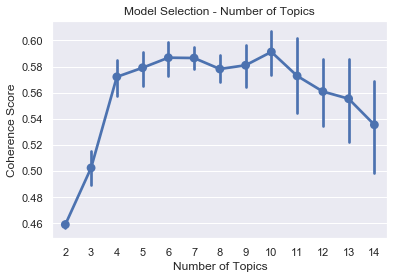

In [25]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.pointplot(x="Topics", y="Coherence", data=model_results)
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
ax.set_title("Model Selection - Number of Topics")

In [32]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           per_word_topics=True,
                                           alpha=0.31,
                                           eta = 0.01
                                           ) # topics 15

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=15))
#doc_lda = lda[corpus]

[(0,
  '0.022*"rubber" + 0.020*"copolymer" + 0.016*"ethylene" + 0.015*"block" + '
  '0.015*"propylene" + 0.014*"weight" + 0.012*"composition" + 0.010*"diene" + '
  '0.010*"polypropylene" + 0.010*"elastomer" + 0.010*"part" + 0.009*"polymer" '
  '+ 0.007*"fraction" + 0.007*"fluorinated" + 0.007*"olefin"'),
 (1,
  '0.023*"thermoplastic" + 0.021*"mould" + 0.019*"weight" + 0.014*"part" + '
  '0.014*"polyamide" + 0.011*"mold" + 0.011*"composition" + 0.011*"foam" + '
  '0.010*"polymer" + 0.009*"impact" + 0.009*"flame" + 0.009*"polycarbonate" + '
  '0.009*"moulding" + 0.009*"graft" + 0.009*"material"'),
 (2,
  '0.018*"acid" + 0.012*"glycol" + 0.012*"starch" + 0.009*"mix" + '
  '0.009*"alcohol" + 0.009*"fatty" + 0.008*"continuous" + '
  '0.008*"polysaccharide" + 0.008*"ester" + 0.008*"dicarboxylic" + '
  '0.007*"melt" + 0.007*"aliphatic" + 0.007*"extruder" + 0.007*"wax" + '
  '0.006*"water"'),
 (3,
  '0.021*"alkyl" + 0.019*"group" + 0.017*"formula" + 0.015*"ch2" + '
  '0.015*"unit" + 0.013*"bon

In [39]:
print('\nPerplexity:', lda_model.log_perplexity(tfidf_matrix))

coherence_score_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Perplexity: -18.079493589533374

Coherence Score: 0.6333319217149314


In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_matrix, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.012337 -0.047179       1        1  13.106261
4     -0.045093 -0.092932       2        1  11.618938
5     -0.165708  0.180238       3        1  10.935040
1     -0.162291  0.101407       4        1  10.595632
9     -0.002234  0.058088       5        1   9.784684
3      0.320758 -0.002128       6        1   9.655991
0     -0.118923  0.112003       7        1   9.523169
6      0.311404  0.083999       8        1   9.205237
2     -0.069372 -0.098685       9        1   8.184769
8     -0.080879 -0.294811      10        1   7.390279, topic_info=          Term         Freq        Total Category  logprob  loglift
7      monomer  3903.000000  3903.000000  Default  30.0000  30.0000
66     formula  3743.000000  3743.000000  Default  29.0000  29.0000
373   catalyst  3157.000000  3157.000000  Default  28.0000  28.0000
1795     contg  1945.000000  1945.000000  Default  27.0000  27.0000
91       alkyl  4161.000000  4161.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
232        mol   445.730469  2129.957764  Topic10  -5.0889   1.0409
79      rubber   454.648651  3086.129639  Topic10  -5.0691   0.6899
154    styrene   381.640442  1986.182617  Topic10  -5.2441   0.9555
344       poly   349.365326  1146.480225  Topic10  -5.3325   1.4167
118     filler   370.081665  1874.035767  Topic10  -5.2749   0.9829

[738 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
494       5  0.005668        10c
494       6  0.893119        10c
494       8  0.025101        10c
494      10  0.076923        10c
5024      7  0.997072      10min
...     ...       ...        ...
2455      8  0.952467       zinc
2263      5  0.999259  zirconium
1257      5  0.323646       zone
1257      9  0.668172       zone
1257     10  0.008352       zone

[1952 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 2, 10, 4, 1, 7, 3, 9])

In [41]:
# look at the degree of assosciation
lda_model[corpus[60]] # corpus[0] means the first document.

([(0, 0.32423922), (4, 0.14465395), (5, 0.35536894), (9, 0.13740206)],
 [(0, [9, 5, 4, 0]),
  (3, [0, 4, 5, 9]),
  (27, [0, 5, 4]),
  (53, [5, 0, 4]),
  (73, [5, 0]),
  (110, [0, 4, 5, 9]),
  (124, [0, 4, 9]),
  (160, [0, 5, 4, 9]),
  (186, [4, 9, 5]),
  (195, [5, 0, 9, 4]),
  (207, [5, 0, 4, 9]),
  (254, [0, 5, 9, 4]),
  (267, [0, 5, 9]),
  (268, [5]),
  (269, [0, 5, 9]),
  (270, [4, 0]),
  (271, [0]),
  (272, [5, 0]),
  (273, [0, 5, 4, 9]),
  (274, [5, 9, 2]),
  (275, [5, 9, 0, 4]),
  (276, [9]),
  (277, [9, 4, 5, 0]),
  (278, [0, 9]),
  (279, [0, 5]),
  (280, [0, 9])],
 [(0, [(0, 0.31555897), (4, 0.34066236), (5, 0.57597274), (9, 0.7568671)]),
  (3, [(0, 0.43209663), (4, 0.2827313), (5, 0.22757924), (9, 0.054514747)]),
  (27, [(0, 1.7424473), (4, 0.09590853), (5, 1.1479263)]),
  (53, [(0, 0.28452787), (4, 0.039586563), (5, 0.6678447)]),
  (73, [(0, 0.011586719), (5, 1.9791244)]),
  (110, [(0, 0.64783984), (4, 0.1652708), (5, 0.14515059), (9, 0.03535578)]),
  (124, [(0, 1.0093812), (

## 3.2. NMF Model

In [34]:
from gensim.models.nmf import Nmf

nmf = Nmf(corpus=tfidf_matrix,
    id2word=id2word,
    num_topics=10,
    chunksize=2000,
    passes=5,
    random_state=42,
    normalize=True
)

In [35]:
nmf.show_topics(num_topics=10,num_words=15,formatted=False)

[(0,
  [('acid', 0.035181263860252554),
   ('polyester', 0.016535282380055),
   ('ester', 0.015428120433247313),
   ('carboxylic', 0.012336376110597612),
   ('salt', 0.011296286987592745),
   ('aliphatic', 0.010517416895904514),
   ('dicarboxylic', 0.010293317947422508),
   ('metal', 0.008519328205906597),
   ('polyamide', 0.008489935827254937),
   ('aromatic', 0.007903893146268978),
   ('alcohol', 0.007593145681939574),
   ('anhydride', 0.00702029482526087),
   ('fatty', 0.006635937560514585),
   ('material', 0.006032768290389049),
   ('mixture', 0.0054118496193088055)]),
 (1,
  [('dispersion', 0.028240586449183),
   ('aqueous', 0.021020056021399634),
   ('water', 0.015495912034961055),
   ('particle', 0.013296736451714902),
   ('coat', 0.012745856434909287),
   ('polymer', 0.011719921213227449),
   ('phase', 0.008231820897738414),
   ('binder', 0.007301621727050534),
   ('powder', 0.00707616414513236),
   ('dry', 0.006652947581233386),
   ('disperse', 0.006598961556285834),
   ('emul

In [36]:

coherence_score_nmf = CoherenceModel(model=nmf, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_nmf.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Coherence Score: 0.6467046860746919


## 3.3. LSA

In [37]:
lsi_model = LsiModel(corpus, num_topics=10, id2word=id2word)
pprint(lsi_model.print_topics(num_words=20))

[(0,
  '0.446*"group" + 0.316*"weight" + 0.257*"contain" + 0.231*"polymer" + '
  '0.202*"compound" + 0.192*"alkyl" + 0.163*"acid" + 0.161*"monomer" + '
  '0.160*"optionally" + 0.146*"component" + 0.146*"formula" + '
  '0.144*"composition" + 0.129*"mixture" + 0.121*"atom" + 0.121*"base" + '
  '0.114*"copolymer" + 0.106*"radical" + 0.088*"process" + 0.087*"form" + '
  '0.080*"part"'),
 (1,
  '0.562*"weight" + -0.498*"group" + -0.217*"alkyl" + 0.207*"polymer" + '
  '0.182*"monomer" + -0.164*"formula" + 0.140*"part" + 0.139*"copolymer" + '
  '0.137*"base" + -0.123*"compound" + -0.122*"atom" + 0.109*"mixture" + '
  '-0.107*"aryl" + -0.092*"optionally" + 0.090*"styrene" + 0.079*"composition" '
  '+ -0.077*"substitute" + -0.076*"20c" + 0.076*"graft" + -0.072*"radical"'),
 (2,
  '-0.532*"alkyl" + -0.294*"weight" + 0.253*"group" + -0.236*"formula" + '
  '-0.204*"aryl" + 0.169*"component" + -0.154*"10c" + -0.152*"20c" + '
  '0.142*"isocyanate" + -0.141*"radical" + 0.140*"contain" + '
  '-0.117*"

In [38]:
coherence_score_lsi = CoherenceModel(model=lsi_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lsi.get_coherence()

print('\nCoherence Score:', coherence_score)


Coherence Score: 0.40799508816178787


# 4. Results and Visualisations
<a id="chap5"></a>
The last section visualizes the results from our final model (again NMF like in the first use case). We will look at the technological concetration (dominant regional cluster compared to the general corpus cluster distribution) and relevant peer regions. We will also look at some abstracts using tagging and highlighting.

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=sentences, ids=appids, ipcs=ipcs, ctr=ctr, nuts=nuts):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_list = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        #row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #print(round(prop_topic,4))
                sent_topics_list.append([int(topic_num),round(prop_topic,4),topic_keywords])
            else:
                break
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df=pd.DataFrame(sent_topics_list,columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    contents = pd.Series(texts[0:len(corpus)])
    appid = pd.Series(ids[0:len(corpus)])
    ipcs = pd.Series(ipcs[0:len(corpus)])
    ctr = pd.Series(ctr[0:len(corpus)])
    nuts = pd.Series(nuts[0:len(corpus)])
    sent_topics_df = pd.concat([sent_topics_df, contents,appid,ipcs,ctr,nuts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=nmf, corpus=corpus, texts=sentences, ids=appids,ipcs=ipcs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','ids','ipcs','ctr','nuts']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.5867   
1            1               1              0.5626   
2            2               1              0.5509   
3            3               1              0.5678   
4            4               1              0.5438   
5            5               1              0.5459   
6            6               1              0.5354   
7            7               1              0.5568   
8            8               1              0.5534   
9            9               1              0.5888   

                                            Keywords  \
0  dispersion, aqueous, water, particle, coat, po...   
1  dispersion, aqueous, water, particle, coat, po...   
2  dispersion, aqueous, water, particle, coat, po...   
3  dispersion, aqueous, water, particle, coat, po...   
4  dispersion, aqueous, water, particle, coat, po...   
5  dispersion, aqueous, water, particle, coat, po...   
6  dispersion, aqueous, water, particle, coat, po...   
7  dispersion, aqueous, water, particle, coat, po...   
8  dispersion, aqueous, water, particle, coat, po...   
9  dispersion, aqueous, water, particle, coat, po...   

                                                Text    ids  ipcs ctr   nuts  
0  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
1  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
2  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
3  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
4  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
5  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
6  A process for the preparation of monodisperse ...  96224  C08F  NO  NO011  
7  A process for the preparation of monodisperse ...  96224  C08F  NO  NO012  
8  A process for the preparation of monodisperse ...  96224  C08F  NO  NO012  
9  A process for the preparation of monodisperse ...  96224  C08F  NO  NO012

In [53]:
group = 9
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['Keywords'].iloc[0]

'propylene, ethylene, copolymer, film, layer, polypropylene, olefin, block, melt, polyolefin'

In [54]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group].sort_values(by=['Topic_Perc_Contrib']).tail(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
14045         14045               9                 1.0   
14044         14044               9                 1.0   
14000         14000               9                 1.0   
13999         13999               9                 1.0   
201857       201857               9                 1.0   
201869       201869               9                 1.0   
10821         10821               9                 1.0   
157973       157973               9                 1.0   
120075       120075               9                 1.0   
86990         86990               9                 1.0   
86988         86988               9                 1.0   
120073       120073               9                 1.0   
120072       120072               9                 1.0   
120070       120070               9                 1.0   
120065       120065               9                 1.0   
157963       157963               9                 1.0   
120062       120062               9                 1.0   
120061       120061               9                 1.0   
10822         10822               9                 1.0   
201868       201868               9                 1.0   

                                                 Keywords  \
14045   propylene, ethylene, copolymer, film, layer, p...   
14044   propylene, ethylene, copolymer, film, layer, p...   
14000   propylene, ethylene, copolymer, film, layer, p...   
13999   propylene, ethylene, copolymer, film, layer, p...   
201857  propylene, ethylene, copolymer, film, layer, p...   
201869  propylene, ethylene, copolymer, film, layer, p...   
10821   propylene, ethylene, copolymer, film, layer, p...   
157973  propylene, ethylene, copolymer, film, layer, p...   
120075  propylene, ethylene, copolymer, film, layer, p...   
86990   propylene, ethylene, copolymer, film, layer, p...   
86988   propylene, ethylene, copolymer, film, layer, p...   
120073  propylene, ethylene, copolymer, film, layer, p...   
120072  propylene, ethylene, copolymer, film, layer, p...   
120070  propylene, ethylene, copolymer, film, layer, p...   
120065  propylene, ethylene, copolymer, film, layer, p...   
157963  propylene, ethylene, copolymer, film, layer, p...   
120062  propylene, ethylene, copolymer, film, layer, p...   
120061  propylene, ethylene, copolymer, film, layer, p...   
10822   propylene, ethylene, copolymer, film, layer, p...   
201868  propylene, ethylene, copolymer, film, layer, p...   

                                                     Text        ids  ipcs  \
14045   Heterophasic propylene copolymer (HECO) compri...  328736645  C08F   
14044   Heterophasic propylene copolymer (HECO) compri...  328736645  C08L   
14000   Fiber reinforced composition comprising a hete...  267762049  C08L   
13999   Fiber reinforced composition comprising a hete...  267762049  C08L   
201857  Disclosed are composite films comprising: A) a...   17049462  C08L   
201869  Disclosed are composite films comprising: A) a...   17049462  C08F   
10821   The present invention relates to nucleated pro...  457014990  C08F   
157973  Propylene copolymer having a comonomer content...  419852654  C08F   
120075  The present invention relates to a biaxially o...  315458284  C08F   
86990   The present invention relates to a biaxially o...   16294799  C08J   
86988   The present invention relates to a biaxially o...   16294799  C08J   
120073  The present invention relates to a biaxially o...  315458284  C08F   
120072  The present invention relates to a biaxially o...  315458284  C08J   
120070  The present invention relates to a biaxially o...  315458284  C08F   
120065  The present invention relates to a biaxially o...  315458284  C08F   
157963  Propylene copolymer having a comonomer content...  419852654  C08L   
120062  The present invention relates to a biaxially o...  315458284  C08F   
120061  The present invention relates to a biaxially o...  315458284  C08F   
1082

In [80]:
j = 14045
sentences[j]

'Heterophasic propylene copolymer (HECO) comprising \\n (a) a polypropylene matrix comprising \\n (a 1 ) a first propylene homopolymer fraction (PPH1) with a melt flow rate MFR 2 (230Â°C) measured according to ISO 1133 in the range of > 200 to 500 g/10min \\n (a 2-1 ) a second propylene homopolymer fraction (PPH2) with a melt flow rate MFR 2 (230Â°C) measured according to ISO 1133 in the range of > 30 to â€°Â¤ 200 g/10min or \\n (a 2-2 ) a second propylene homopolymer fraction (PPH2) with a melt flow rate MFR 2 (230Â°C) measured according to ISO 1133 in the range of > 5 to â€°Â¤ 30 g/10min and \\n (a 3-1 ) a third propylene homopolymer fraction (PPH3) with a melt flow rate MFR 2 (230Â°C) measured according to ISO 1133 in the range of 0.03 to â€°Â¤ 5 g/10min, if the second propylene homopolymer fraction is fraction (a 2-1 ) or \\n (a 3-2 ) a third propylene homopolymer fraction (PPH3) with a melt flow rate MFR 2 (230Â°C) measured according to ISO 1133 in the range of > 30 to â€°Â¤ 200 g

In [81]:
for i in id2word.doc2idx(corpuslist[j]):
    print(id2word[i])
    print(nmf.get_term_topics(i,minimum_probability = .3))

heterophasic
[(9, 1.0)]
propylene
[(9, 0.9925782120634635)]
copolymer
[(9, 0.42349040525595555)]
heco
[(9, 1.0)]
polypropylene
[(9, 1.0)]
matrix
[(1, 0.3051307062560237), (5, 0.3201126921996894), (9, 0.37475660154428675)]
propylene
[(9, 0.9925782120634635)]
homopolymer
[(2, 0.31814668511682676), (9, 0.6307935672284111)]
fraction
[(9, 0.8575498821515535)]
pph1
[(9, 1.0)]
melt
[(9, 0.5855549029887496)]
flow
[(9, 0.7124258992930224)]
rate
[(9, 0.7952920402654068)]
mfr
[(9, 1.0)]
230â
[(9, 1.0)]
measure
[(9, 0.5119961389498704)]
iso
[(9, 0.6752523404607589)]
range
[(2, 0.38657839611109196)]
10min
[(9, 1.0)]
propylene
[(9, 0.9925782120634635)]
homopolymer
[(2, 0.3181466851168268), (9, 0.6307935672284112)]
fraction
[(9, 0.8575498821515535)]
pph2
[(9, 1.0)]
melt
[(9, 0.5855549029887496)]
flow
[(9, 0.7124258992930224)]
rate
[(9, 0.7952920402654068)]
mfr
[(9, 1.0)]
230â
[(9, 1.0)]
measure
[(9, 0.5119961389498704)]
iso
[(9, 0.6752523404607589)]
range
[(2, 0.386578396111092)]
10min
[(9, 1.0)]
pro

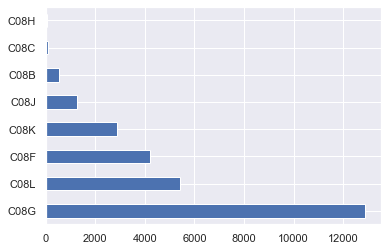

In [50]:
ax = df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['ipcs'].value_counts()[:20].plot(kind='barh')

In [213]:
domipcs = pd.DataFrame(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['ipcs'].value_counts()[:20])

[Text(0, 0.5, 'Topic'), Text(0.5, 0, 'Number of Documents')]

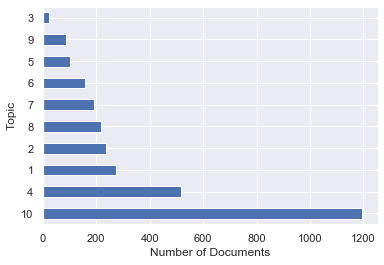

In [74]:
ax = df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]['Dominant_Topic'].value_counts()[:20].plot(kind='barh')
ax.set(xlabel='Number of Documents', ylabel='Topic')
#ax.set_title("Model Selection - Number of Topics")

In [71]:
df_dominant_topic["Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]+1

[Text(0, 0.5, 'Topic'), Text(0.5, 0, 'Number of Documents')]

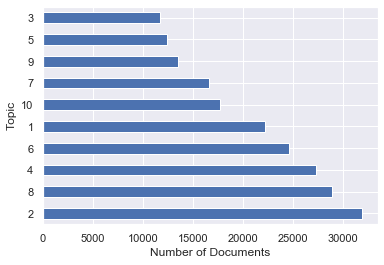

In [76]:
ax = df_dominant_topic['Dominant_Topic'].value_counts()[:20].plot(kind='barh')
ax.set(xlabel='Number of Documents', ylabel='Topic')
#ax.set_title("Model Selection - Number of Topics")

In [55]:
df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
59               59               9              0.6188   
60               60               9              0.5826   
61               61               9              0.5855   
62               62               9              0.5880   
394             394               0              0.3524   
...             ...             ...                 ...   
206957       206957               9              0.7490   
206958       206958               9              0.7487   
206998       206998               9              0.4090   
206999       206999               9              0.3794   
207028       207028               9              0.7712   

                                                 Keywords  \
59      propylene, ethylene, copolymer, film, layer, p...   
60      propylene, ethylene, copolymer, film, layer, p...   
61      propylene, ethylene, copolymer, film, layer, p...   
62      propylene, ethylene, copolymer, film, layer, p...   
394     acid, polyester, ester, carboxylic, salt, alip...   
...                                                   ...   
206957  propylene, ethylene, copolymer, film, layer, p...   
206958  propylene, ethylene, copolymer, film, layer, p...   
206998  propylene, ethylene, copolymer, film, layer, p...   
206999  propylene, ethylene, copolymer, film, layer, p...   
207028  propylene, ethylene, copolymer, film, layer, p...   

                                                     Text        ids  ipcs  \
59      The present invention relates to a process for...     152397  C08K   
60      The present invention relates to a process for...     152397  C08K   
61      The present invention relates to a process for...     152397  C08K   
62      The present invention relates to a process for...     152397  C08K   
394     Gelcoat formulations comprising an unsaturated...   16189572  C08L   
...                                                   ...        ...   ...   
206957  A polypropylene copolymer comprising monomer u...  330220357  C08F   
206958  A polypropylene copolymer comprising monomer u...  330220357  C08F   
206998  A masterbatch (MB) comprising, preferably cons...  413701230  C08L   
206999  A masterbatch (MB) comprising, preferably cons...  413701230  C08J   
207028  The present invention is concerned with biaxia...  472784144  C08J   

       ctr   nuts  
59      AT  AT312  
60      AT  AT312  
61      AT  AT313  
62      AT  AT313  
394     AT  AT221  
...     ..    ...  
206957  AT  AT313  
206958  AT  AT313  
206998  AT  AT312  
206999  AT  AT312  
207028  AT  AT313  

[2995 rows x 9 columns]

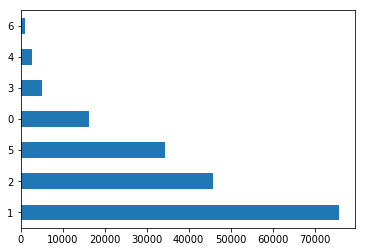

In [80]:
df_dominant_topic['Dominant_Topic'].value_counts()[:20].plot(kind='barh')

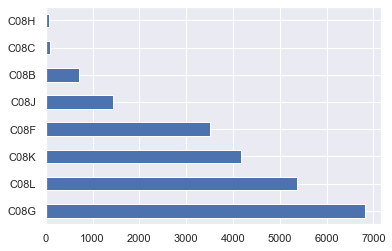

In [56]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==0]['ipcs'].value_counts()[:20].plot(kind='barh')

In [64]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==9]['nuts'].value_counts().to_csv("peers.csv")

In [84]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==10]['nuts'].value_counts().head(20)

AT312    906
FI1B1    484
DE71A    471
ITH56    470
ITC4C    388
FR231    387
DEB35    384
SE232    331
BE100    315
DEB3C    304
BE310    300
DEB3J    294
DE714    258
DEB34    237
NL423    232
AT313    225
DE128    212
DE712    200
DEA14    196
DEB3I    196
Name: nuts, dtype: int64

***
### Bibliography
<a id="bibl"></a>
[1] https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

[2] https://stevenloria.com/tf-idf/

[3] https://pynative.com/python-postgresql-tutorial/

[4] https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

[5] https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created

[6] https://gdcoder.com/nlp-tutorial-topic-modeling-with-svd/

[7] https://gdcoder.com/all-you-need-to-know-about-nlp-text-preprocessing/

[8] Bengfort, B., Bilbro, R., & Ojeda, T. (2018). Applied Text Analysis with Python: Enabling Language-aware Data Products with Machine Learning. " O'Reilly Media, Inc.".

[9] Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. " O'Reilly Media, Inc.".

[10] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

[11] https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

[12] https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

***
#### [>>> return to top](#top)